# 3rd Level Model Structure: Single Stage Reactive Distillation

In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))

import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets

In [2]:
from pyomo import environ as pe
from modules.global_set import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule

from utility.display_utility import trans_product_mole, trans_product_mass, beautify2
from utility.model_utility import add_dual, update_dual, check_DOF
from utility.data_utility import cal_cnumber

model = pe.ConcreteModel()

# Global Set

In [3]:
model.TRAY = pe.RangeSet(1,5)

# Construct Reactive Stages

In [4]:
model.reactive = pe.Block(model.TRAY,rule=reactive_stage_rule)

> Importing Reactive Stage......
> Adding the following local variable:
------------------------------------
| reactive[1].T_F
| reactive[1].P
| reactive[1].cat
| reactive[1].Q_main
| reactive[1].x_
| reactive[1].y_
| reactive[1].x
| reactive[1].y
| reactive[1].z
| reactive[1].L
| reactive[1].V
| reactive[1].F
| reactive[1].H_L_
| reactive[1].H_V_
| reactive[1].H_L
| reactive[1].H_V
| reactive[1].T
| reactive[1].H_F
| reactive[1].f_V
| reactive[1].f_L
| reactive[1].r_total_comp
------------------------------------

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| reactive[1].kinetics_block.k_FT
| reactive[1].kinetics_block.r_FT_total
| reactive[1].kinetics_block.g0_FT
| reactive[1].kinetics_block.alpha
| reactive[1].kinetics_block.r_FT_cnum
| reactive[1].kinetics_block.r_FT_comp
| reactive[1].kinetics_block.k_WGS
| reactive[1].kinetics_block.Ke_WGS
| reactive[1].kinetics_block.r_WGS
| reactive[1].kinetics_bloc

> Importing Reactive Stage......
> Adding the following local variable:
------------------------------------
| reactive[5].T_F
| reactive[5].P
| reactive[5].cat
| reactive[5].Q_main
| reactive[5].x_
| reactive[5].y_
| reactive[5].x
| reactive[5].y
| reactive[5].z
| reactive[5].L
| reactive[5].V
| reactive[5].F
| reactive[5].H_L_
| reactive[5].H_V_
| reactive[5].H_L
| reactive[5].H_V
| reactive[5].T
| reactive[5].H_F
| reactive[5].f_V
| reactive[5].f_L
| reactive[5].r_total_comp
------------------------------------

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| reactive[5].kinetics_block.k_FT
| reactive[5].kinetics_block.r_FT_total
| reactive[5].kinetics_block.g0_FT
| reactive[5].kinetics_block.alpha
| reactive[5].kinetics_block.r_FT_cnum
| reactive[5].kinetics_block.r_FT_comp
| reactive[5].kinetics_block.k_WGS
| reactive[5].kinetics_block.Ke_WGS
| reactive[5].kinetics_block.r_WGS
| reactive[5].kinetics_bloc

# Construct a single condenser

In [5]:
model.condenser = pe.Block(rule=condenser_stage_rule)

| Importing Condenser Stage......
| Adding the following local variable:
------------------------------------
| condenser.T
| condenser.T_F
| condenser.P
| condenser.Q_main
| condenser.x_
| condenser.y_
| condenser.x
| condenser.y
| condenser.z
| condenser.L
| condenser.W
| condenser.V
| condenser.F
| condenser.H_L_
| condenser.H_V_
| condenser.H_L
| condenser.H_V
| condenser.H_F
| condenser.f_V
| condenser.f_L
------------------------------------

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| condenser.energy_block.dH_F
| condenser.energy_block.dH_V
| condenser.energy_block.dH_L
| condenser.energy_block.dH_vap
--------------------------------------------------

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| condenser.VLE_block.n_ave
| condenser.VLE_block.n_ave_cal
| condenser.VLE_block.Hen
| condenser.VLE_block.Hen0
| condenser.VLE_blo

# Linking Stage Variables

### Vapor Between Reactive Stages

In [6]:
def V_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].V['in'] == model.reactive[j+1].V['out']
model.V_between_con = pe.Constraint(model.TRAY,rule=V_between_rule)

def Vy_between_rule(model,j,i):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].y_['in',i] == model.reactive[j+1].y[i]
model.Vy_between_con = pe.Constraint(model.TRAY,m.COMP_TOTAL,rule=Vy_between_rule)

def Vh_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].H_V_['in'] == model.reactive[j+1].H_V
model.Vh_between_con = pe.Constraint(model.TRAY,rule=Vh_between_rule)

### Liquid Between Reactive Stages

In [7]:
def L_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].L['in'] == model.reactive[j].L['out']
model.L_between_con = pe.Constraint(model.TRAY,rule=L_between_rule)

def Lx_between_rule(model,j,i):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].x_['in',i] == model.reactive[j].x[i]
model.Ly_between_con = pe.Constraint(model.TRAY,m.COMP_TOTAL,rule=Lx_between_rule)

def Lh_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].H_L_['in'] == model.reactive[j].H_L
model.Lh_between_con = pe.Constraint(model.TRAY,rule=Lh_between_rule)

### Condenser

In [8]:
def V_condenser_rule(model):
    return model.reactive[model.TRAY.first()].V['out'] == model.condenser.V['in']
model.V_condenser_con = pe.Constraint(rule=V_condenser_rule)

def Vy_condenser_rule(model,i):
    return model.reactive[model.TRAY.first()].y[i] == model.condenser.y_['in',i]
model.Vy_condenser_con = pe.Constraint(m.COMP_TOTAL,rule=Vy_condenser_rule)

def Vh_condenser_rule(model):
    return model.reactive[model.TRAY.first()].H_V == model.condenser.H_V_['in']
model.Vh_condenser_con = pe.Constraint(rule=Vh_condenser_rule)

In [9]:
def L_condenser_rule(model):
    return model.reactive[model.TRAY.first()].L['in'] == model.condenser.L['out']
model.L_condenser_con = pe.Constraint(rule=L_condenser_rule)

def Lx_condenser_rule(model,i):
    return model.reactive[model.TRAY.first()].x_['in',i] == model.condenser.x[i]
model.Lx_condenser_con = pe.Constraint(m.COMP_TOTAL,rule=Lx_condenser_rule)

def Lh_condenser_rule(model):
    return model.reactive[model.TRAY.first()].H_L_['in'] == model.condenser.H_L
model.Lh_condenser_con = pe.Constraint(rule=Lh_condenser_rule)

In [10]:
model.obj = pe.Objective(expr = sum(model.reactive[j].T for j in model.TRAY) ,sense=pe.maximize)

# Load from single stage solutions

In [11]:
with open('../saved_solutions/1_stage_condenser_adiabatic.pickle', 'rb') as f:
    results_imported = pickle.load(f)
results_changed = results_imported

### Duplicate variable solution and bounds multiplier

In [12]:
for i in list(results_imported.Solution.Variable.keys()):
    if i.startswith('reactive[1].'):
        for j in model.TRAY:
            if j != 1:
                results_changed.Solution.Variable[i.replace('reactive[1].','reactive[{}].'.format(j))] = \
                results_imported.Solution.Variable[i]

### Duplicate constraint multiplier

In [13]:
for i in list(results_changed.Solution.Constraint.keys()):
    if i.startswith('reactive[1].'):
        for j in model.TRAY:
            if j != 1:
                results_changed.Solution.Constraint[i.replace('reactive[1].','reactive[{}].'.format(j))] = \
                results_imported.Solution.Constraint[i]

### Load changed solution into current model

In [14]:
model.solutions.load_from(results_changed)

# Fixing Redundent Stream Variables

In [15]:
# condenser
model.condenser.VLE_block.n_ave.fix(4)

model.condenser.F.fix(0)
model.condenser.T_F.fix(300+273.15)
model.condenser.z.fix(0)

model.condenser.V['P'].fix(0)
model.condenser.L['in'].fix(0)
for i in m.COMP_TOTAL: model.condenser.x_['in',i].fix(0)
model.condenser.H_L_['in'].fix(0)

In [16]:
# 'reboiler' fixing last stage V_in

model.reactive[model.TRAY.last()].V['in'].fix(0)
for i in m.COMP_TOTAL: model.reactive[model.TRAY.last()].y_['in',i].fix(0)
model.reactive[model.TRAY.last()].H_V_['in'].fix(0)

# Load Operating Parameters

In [17]:
# condenser
model.condenser.P.fix(19)
# model.condenser.T.fix(30+273.15)
model.condenser.T.fix(30+273.15)
model.condenser.L['out'].fix(0)

# reactive stage
for j in model.reactive:
    model.reactive[j].cat.fix(5000)
    model.reactive[j].P.fix(20)
    model.reactive[j].VLE_block.n_ave.fix(20)
    
    model.reactive[j].F.fix(1)
    model.reactive[j].T_F.fix(200+273.15)
    model.reactive[j].z['CO'].fix(1/(1+2))
    model.reactive[j].z['H2'].fix(2/(1+2))
    model.reactive[j].z['C30H62'].fix(0)
    model.reactive[j].V['P'].fix(0)
    model.reactive[j].L['P'].fix(0)
    # model.reactive[j].Q_main.fix(0)
    model.reactive[j].T.setub(240+273.15)

In [18]:
check_DOF(pe,model)

Active Equality Constraints:	 7672
Active Inequality Constraints:	 0
Active Variables:		 7899
Fixed Variables:		 222
DOF:				 5


In [19]:
opt = pe.SolverFactory('ipopt')
opt.options['print_user_options'] = 'yes'
opt.options['linear_solver'] = 'ma86'
# opt.options['nlp_scaling_method'] = None
# opt.options['constr_viol_tol'] = 1e-7
# opt.options['acceptable_constr_viol_tol'] = 1e-7
opt.options['max_iter'] = 7000
# opt.options['dual_inf_tol'] = '+inf'
# opt.options['acceptable_dual_inf_tol'] = '+inf'

In [20]:
add_dual(pe,model)
update_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


In [21]:
results = opt.solve(model,tee=True)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
max_iter=7000


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma86                  yes
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    25272
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.....

  74 -2.5657500e+03 5.55e+03 3.89e+06  -1.0 5.63e+03  -1.2 3.46e-03 1.41e-02h  1
  75 -2.5657500e+03 5.55e+03 3.93e+06  -1.0 5.99e+03    -  8.40e-04 2.23e-04h  1
  76 -2.5657500e+03 5.47e+03 3.97e+06  -1.0 5.55e+03  -1.7 2.41e-02 1.48e-02h  1
  77 -2.5657500e+03 5.46e+03 3.90e+06  -1.0 5.47e+03    -  4.18e-04 2.07e-03h  1
  78 -2.5657500e+03 5.45e+03 4.00e+06  -1.0 5.46e+03    -  3.97e-03 2.06e-03h  1
  79 -2.5657500e+03 5.43e+03 3.92e+06  -1.0 5.45e+03    -  1.70e-03 3.28e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -2.5657500e+03 5.42e+03 3.94e+06  -1.0 5.43e+03    -  2.05e-03 1.53e-03h  1
  81 -2.5657500e+03 5.42e+03 4.12e+06  -1.0 5.42e+03    -  4.07e-03 7.39e-04h  1
  82 -2.5657500e+03 5.41e+03 4.06e+06  -1.0 5.42e+03    -  4.70e-03 1.58e-03h  1
  83 -2.5657500e+03 5.39e+03 4.33e+06  -1.0 5.41e+03    -  1.65e-02 2.76e-03h  1
  84 -2.5657500e+03 5.38e+03 4.32e+06  -1.0 5.39e+03    -  1.95e-03 3.26e-03h  1
  85 -2.5657500e+03 5.35e+03

 167 -2.5657481e+03 5.08e+01 4.52e+04  -1.0 5.70e+00   3.7 1.10e-02 4.78e-05h  1
 168 -2.5657491e+03 5.06e+01 7.15e+04  -1.0 8.26e+00   3.2 1.06e-02 2.70e-03h  1
 169 -2.5657493e+03 5.05e+01 8.29e+04  -1.0 1.03e+01   2.7 1.15e-02 1.57e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 -2.5657500e+03 5.01e+01 8.24e+04  -1.0 1.17e+01   2.3 8.81e-03 8.18e-03h  1
 171 -2.5657500e+03 5.00e+01 8.32e+04  -1.0 1.35e+01   1.8 2.67e-02 2.89e-03h  1
 172 -2.5657500e+03 4.90e+01 8.07e+04  -1.0 1.51e+01   1.3 3.69e-02 1.89e-02h  1
 173 -2.5657500e+03 4.71e+01 7.80e+04  -1.0 2.95e+01   0.8 3.35e-02 4.01e-02h  1
 174 -2.5657500e+03 4.68e+01 7.26e+04  -1.0 1.42e+01   1.3 9.40e-02 5.10e-03h  1
 175 -2.5657500e+03 4.53e+01 7.12e+04  -1.0 4.83e+01   0.8 2.00e-02 3.22e-02h  1
 176 -2.5657500e+03 4.49e+01 6.41e+04  -1.0 1.37e+01   1.2 1.28e-01 1.02e-02h  1
 177 -2.5657500e+03 4.35e+01 6.10e+04  -1.0 4.00e+01   0.7 4.65e-02 3.05e-02h  1
 178 -2.5657500e+03 4.26e+01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 -2.5657462e+03 1.83e-02 2.40e+06  -1.0 7.34e-01   1.5 1.66e-01 2.34e-01f  1
 261 -2.5657458e+03 1.41e-02 2.06e+06  -1.0 2.49e+00   1.0 1.53e-01 2.12e-01f  2
 262 -2.5657458e+03 1.39e-02 1.98e+06  -1.0 7.00e+00   0.5 5.04e-02 1.34e-02h  4
 263 -2.5657456e+03 6.98e-03 2.44e+06  -1.0 3.29e-01   1.9 1.42e-01 5.00e-01f  2
 264 -2.5657456e+03 6.58e-03 1.81e+06  -1.0 9.04e-01   1.4 2.01e-01 5.64e-02f  4
 265 -2.5657454e+03 3.29e-03 1.75e+06  -1.0 3.73e-01   1.8 2.59e-01 5.00e-01f  2
 266 -2.5657453e+03 2.78e-03 1.45e+06  -1.0 9.90e-01   1.3 1.69e-01 1.50e-01f  2
 267 -2.5657451e+03 2.63e-03 1.26e+06  -1.0 3.10e+00   0.9 2.13e-01 8.14e-02H  1
 268 -2.5657448e+03 1.00e-02 1.09e+06  -1.0 8.55e+00   0.4 1.03e-01 1.03e-01s 19
 269 -2.5657447e+03 7.55e-03 7.98e+05  -1.0 4.06e-01   1.7 2.68e-01 2.68e-01s 19
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 -2.5657444e+03 7.85e-03

 514r-2.5657160e+03 2.70e-03 7.81e+02  -8.6 1.44e+01  -5.3 2.04e-02 1.14e-01h  1
 515r-2.5657159e+03 2.67e-03 7.71e+02  -8.6 1.73e+01  -4.9 1.16e-02 1.26e-02h  1
 516r-2.5657156e+03 2.65e-03 7.66e+02  -8.6 1.94e+01  -5.4 5.28e-02 7.05e-03h  1
 517r-2.5657117e+03 2.57e-03 7.43e+02  -8.6 5.62e+01  -5.9 6.33e-03 3.03e-02f  1
 518r-2.5657064e+03 2.54e-03 7.34e+02  -8.6 1.48e+02  -6.3 6.99e-03 1.18e-02f  1
 519r-2.5656972e+03 2.53e-03 7.31e+02  -8.6 3.39e+02  -6.8 2.67e-03 4.13e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520r-2.5656957e+03 2.52e-03 7.29e+02  -8.6 8.06e+01  -6.4 4.44e-04 2.89e-03f  1
 521r-2.5655916e+03 4.58e-03 1.02e+03  -8.6 4.41e+02  -6.9 2.75e-06 3.59e-02f  1
 522r-2.5655916e+03 4.56e-03 1.01e+03  -8.6 7.61e+00  -4.6 6.57e-03 4.13e-03f  1
 523r-2.5655916e+03 4.54e-03 1.03e+03  -8.6 2.59e+00  -3.3 1.61e-04 3.50e-03f  1
 524r-2.5655916e+03 4.52e-03 1.47e+03  -8.6 3.59e+00  -2.9 6.45e-04 5.64e-03h  1
 525r-2.5655916e+03 4.46e-03

 612 -2.5655916e+03 3.70e-04 6.29e+02  -1.0 4.24e+03    -  1.05e-04 1.53e-06f  1
 613 -2.5655915e+03 3.70e-04 5.15e+02  -1.0 1.57e+03    -  2.13e-06 2.31e-04f  1
 614 -2.5655914e+03 3.70e-04 6.36e+02  -1.0 1.46e+03    -  7.25e-04 3.26e-04f  1
 615 -2.5655909e+03 3.69e-04 6.42e+02  -1.0 1.30e+03    -  9.43e-04 1.49e-03f  1
 616 -2.5655898e+03 3.68e-04 9.23e+02  -1.0 1.14e+03    -  5.29e-03 3.52e-03f  1
 617 -2.5655852e+03 3.36e-03 7.90e+02  -1.0 8.47e+02    -  9.52e-03 1.39e-02f  1
 618 -2.5655750e+03 1.50e-02 5.79e+03  -1.0 5.92e+02    -  8.50e-02 3.29e-02f  1
 619 -2.5655234e+03 1.33e-01 2.52e+04  -1.0 2.58e+02    -  5.52e-01 2.00e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 620 -2.5654397e+03 1.91e-01 1.14e+03  -1.0 3.59e+01    -  9.31e-01 1.00e+00f  1
 621 -2.5654360e+03 5.57e-01 7.92e+03  -1.0 7.25e+00    -  7.52e-01 2.50e-01h  3
 622 -2.5654309e+03 6.22e-01 8.07e+03  -1.0 5.21e+00    -  9.90e-01 5.00e-01h  2
 623 -2.5654250e+03 4.81e-01

 706 -2.5657500e+03 3.23e-06 1.18e+01  -5.7 5.81e-01    -  8.06e-01 1.00e+00f  1
 707 -2.5657500e+03 3.17e-06 9.73e-02  -5.7 4.75e-01    -  9.98e-01 1.00e+00h  1
 708 -2.5657500e+03 4.47e-06 2.63e-02  -5.7 8.36e-01    -  1.00e+00 1.00e+00H  1
 709 -2.5657500e+03 1.62e-07 1.77e-03  -5.7 1.24e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 710 -2.5657500e+03 1.08e-07 1.24e-03  -5.7 1.03e-01    -  1.00e+00 1.00e+00h  1
 711 -2.5657500e+03 1.86e-08 4.07e-04  -5.7 4.30e-02    -  1.00e+00 1.00e+00h  1
 712 -2.5657500e+03 1.09e-08 2.84e-04  -5.7 3.31e-02    -  1.00e+00 1.00e+00h  1
 713 -2.5657500e+03 7.93e-09 1.88e-04  -5.7 2.46e-02    -  1.00e+00 1.00e+00h  1
 714 -2.5657500e+03 7.09e-09 1.33e-04  -5.7 1.91e-02    -  1.00e+00 1.00e+00h  1
 715 -2.5657500e+03 6.40e-09 9.75e-05  -5.7 1.53e-02    -  1.00e+00 1.00e+00h  1
 716 -2.5657500e+03 5.81e-09 7.36e-05  -5.7 1.26e-02    -  1.00e+00 1.00e+00h  1
 717 -2.5657500e+03 5.31e-09

In [22]:
update_dual(pe,model)

In [23]:
model.reactive[1].T.setub(210+273.15)
model.reactive[2].T.setub(215+273.15)
model.reactive[3].T.setub(220+273.15)
model.reactive[4].T.setub(225+273.15)
model.reactive[5].T.setub(230+273.15)

In [24]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
max_iter=7000


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma86                  yes
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    25272
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.....

  74 -2.4486322e+03 4.70e+00 8.77e+05  -1.0 8.49e+04    -  1.41e-02 8.76e-04h  5
  75 -2.4472234e+03 4.70e+00 9.82e+05  -1.0 9.20e+04    -  9.56e-03 9.39e-04h  5
  76 -2.4458798e+03 4.69e+00 1.51e+06  -1.0 9.94e+04    -  2.95e-02 8.79e-04h  5
  77 -2.4445985e+03 4.69e+00 1.77e+06  -1.0 1.08e+05    -  8.35e-03 8.27e-04h  5
  78 -2.4433761e+03 4.69e+00 3.14e+06  -1.0 1.14e+05    -  3.45e-02 7.87e-04h  5
  79 -2.4422084e+03 4.68e+00 3.68e+06  -1.0 1.23e+05    -  8.99e-03 7.51e-04h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -2.4410933e+03 4.68e+00 7.31e+06  -1.0 1.28e+05    -  4.37e-02 7.25e-04h  5
  81 -2.4255593e+03 4.35e+01 2.03e+08  -1.0 1.37e+05    -  9.36e-03 1.04e-02w  1
  82 -2.4250522e+03 4.38e+01 2.05e+08  -1.0 9.70e+04    -  5.69e-03 1.12e-03w  1
  83 -2.4250034e+03 4.37e+01 2.05e+08  -1.0 8.88e+04    -  1.30e-02 1.25e-04w  1
  84 -2.4401224e+03 4.68e+00 9.02e+06  -1.0 7.47e+04    -  9.36e-03 6.50e-04h  4
  85 -2.4392686e+03 4.67e+00

 166 -2.4611362e+03 2.20e+01 9.18e+06  -1.0 8.96e+02    -  2.32e-01 2.06e-01f  1
 167 -2.4654589e+03 1.40e+01 3.26e+06  -1.0 8.81e+02    -  1.92e-01 6.67e-01f  1
 168 -2.4655018e+03 1.37e+01 3.21e+06  -1.0 4.14e+02    -  4.03e-02 1.47e-02h  1
 169 -2.4654274e+03 4.00e-02 2.56e+06  -1.0 8.42e+00    -  1.20e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 -2.4654971e+03 2.77e-02 1.83e+06  -1.0 3.41e+01    -  1.00e+00 3.01e-01f  2
 171 -2.4655218e+03 3.80e-04 2.71e+02  -1.0 4.39e+00    -  1.00e+00 1.00e+00h  1
 172 -2.4656271e+03 3.11e-04 8.02e+04  -3.8 3.81e+00    -  9.98e-01 1.00e+00f  1
 173 -2.4657493e+03 3.29e-04 1.23e+02  -3.8 3.48e+00    -  1.00e+00 1.00e+00f  1
 174 -2.4657493e+03 2.82e-10 1.85e-04  -3.8 3.82e-03    -  1.00e+00 1.00e+00h  1
 175 -2.4657500e+03 1.27e-08 1.04e+00  -5.7 2.13e-02    -  1.00e+00 1.00e+00f  1
 176 -2.4657500e+03 2.78e-10 1.42e-08  -5.7 4.49e-05    -  1.00e+00 1.00e+00h  1
 177 -2.4657500e+03 4.10e-10

In [25]:
beautify2(pe,model)

Here comes the result:
----------------------------------------------------------------------------------------------------
		T		 Q			 V			 L
               30.00 	       -72.2282175381 	         0.9434840101 	         0.0000000000
              210.00 	       -44.1733150170 	         2.2168633921 	         0.0109574191
              215.00 	       -45.2464065794 	         1.7500147043 	         0.0211914664
              220.00 	       -45.8479838263 	         1.2999674807 	         0.0300099794
              225.00 	       -46.1486473530 	         0.8607477848 	         0.0368347010
              230.00 	       -46.2802563742 	         0.4282762795 	         0.0412962553
----------------------------------------------------------------------------------------------------
Top
V	 0.9434840100800679
L	 0.07114846320014528
W	 1.20223091882719
----------------------------------------------------------------------------------------------------
Bottom
L	 0.04129625526490978
-----------------

In [26]:
model.reactive[1].kinetics_block.r_FT_total.value

0.2665108235010655

In [27]:
# model.solutions.store_to(results)
# with open('../saved_solutions/5_stage_condenser_220_240C.pickle','wb') as f:
#     pickle.dump(results,f)

In [28]:
model.condenser.L['out'].fixed = False
for j in model.reactive:
    model.reactive[j].T.fixed=True

In [29]:
model.del_component(model.obj)
model.obj = pe.Objective(expr = model.condenser.L['out'],sense=pe.maximize)

# So, what exactly does adding a reflux do?

In [30]:
Refluxrange = np.linspace(0,2,21)

In [31]:
cd_data = {};
cd_data['Re'] = []; cd_data['D'] = []; cd_data['V'] = []
cd_data['x'] = {}; cd_data['y'] = {}; cd_data['g'] = {}; cd_data['d'] = {};
for i in m.COMP_TOTAL:
    cd_data['x'][i] = []
    cd_data['y'][i] = []
    cd_data['g'][i] = []
    cd_data['d'][i] = []
    
rf_data = {}
for j in model.reactive:
    rf_data[j] = {}
    rf_data[j]['r'] = {}; rf_data[j]['b'] = {}; rf_data[j]['x'] = {};rf_data[j]['y'] = {};
    rf_data[j]['T'] = []; rf_data[j]['Q'] = []; rf_data[j]['V'] = []; rf_data[j]['L'] = []; 
    rf_data[j]['r_WGS'] = []; rf_data[j]['r_FT'] = []
    for i in m.COMP_TOTAL:
        rf_data[j]['r'][i] = []
        rf_data[j]['b'][i] = []
        rf_data[j]['x'][i] = []
        rf_data[j]['y'][i] = []       

In [32]:
for re in Refluxrange:
    # model.condenser.L['out'].fixed = False
    model.condenser.L['out'].setub(re)
    # model.reactive[1].T.fix(t)
    results = opt.solve(model,tee=False)
    update_dual(pe,model)
    print('Solved\t|Reflux = {:.3f} kmol/s\t|Vapor = {:.3f} kmol/s\t|Distillate = {:.3f} kmol/s\t|Bottom = {:.3f} kmol/s'.\
          format(model.condenser.L['out'].value,model.condenser.V['out'].value,model.condenser.L['P'].value,model.reactive[3].L['out'].value))

    cd_data['V'].append(model.condenser.V['out'].value)
    cd_data['D'].append(model.condenser.L['P'].value)
    cd_data['Re'].append(model.condenser.L['out'].value)

    for i in model.reactive[1].r_total_comp:
        cd_data['x'][i].append(model.condenser.x[i].value)
        cd_data['y'][i].append(model.condenser.y[i].value)
        cd_data['g'][i].append(model.condenser.y[i].value*model.condenser.V['out'].value)
        cd_data['d'][i].append(model.condenser.x[i].value*model.condenser.L['P'].value)
    
    for j in model.reactive:      
        rf_data[j]['T'].append(model.reactive[j].T.value)
        rf_data[j]['Q'].append(model.reactive[j].Q_main.value)
        rf_data[j]['V'].append(model.reactive[j].V['out'].value)
        rf_data[j]['L'].append(model.reactive[j].L['out'].value)
        rf_data[j]['r_WGS'].append(model.reactive[j].kinetics_block.r_WGS.value)
        rf_data[j]['r_FT'].append(model.reactive[j].kinetics_block.r_FT_total.value)

        for i in model.reactive[1].r_total_comp:
            rf_data[j]['r'][i].append(model.reactive[j].r_total_comp[i].value)
            rf_data[j]['b'][i].append(model.reactive[j].x[i].value*model.reactive[j].L['out'].value)
            rf_data[j]['x'][i].append(model.reactive[j].x[i].value)
            rf_data[j]['y'][i].append(model.reactive[j].y[i].value)

Solved	|Reflux = 0.000 kmol/s	|Vapor = 0.943 kmol/s	|Distillate = 0.071 kmol/s	|Bottom = 0.030 kmol/s
Solved	|Reflux = 0.100 kmol/s	|Vapor = 0.952 kmol/s	|Distillate = 0.066 kmol/s	|Bottom = 0.036 kmol/s
Solved	|Reflux = 0.200 kmol/s	|Vapor = 0.960 kmol/s	|Distillate = 0.061 kmol/s	|Bottom = 0.042 kmol/s
Solved	|Reflux = 0.300 kmol/s	|Vapor = 0.969 kmol/s	|Distillate = 0.057 kmol/s	|Bottom = 0.049 kmol/s
Solved	|Reflux = 0.400 kmol/s	|Vapor = 0.978 kmol/s	|Distillate = 0.054 kmol/s	|Bottom = 0.055 kmol/s
Solved	|Reflux = 0.500 kmol/s	|Vapor = 0.988 kmol/s	|Distillate = 0.051 kmol/s	|Bottom = 0.062 kmol/s
Solved	|Reflux = 0.600 kmol/s	|Vapor = 0.997 kmol/s	|Distillate = 0.048 kmol/s	|Bottom = 0.068 kmol/s
Solved	|Reflux = 0.700 kmol/s	|Vapor = 1.006 kmol/s	|Distillate = 0.045 kmol/s	|Bottom = 0.075 kmol/s
Solved	|Reflux = 0.800 kmol/s	|Vapor = 1.015 kmol/s	|Distillate = 0.043 kmol/s	|Bottom = 0.082 kmol/s
Solved	|Reflux = 0.900 kmol/s	|Vapor = 1.025 kmol/s	|Distillate = 0.041 kmol/s	|Bo

In [33]:
cnumber_range = range(1,57)

In [34]:
def trans_cnumber(dic):
    molefraction = {}
    for i in range(1,57):
        molefraction[i] = []
    for i in m.COMP_ORG:
        molefraction[cal_cnumber(i)].append(np.array(dic[i]))
    for i in range(1,57):
        molefraction[i] = np.sum(molefraction[i],0)
    length = len(molefraction[1])
    tmp = {}
    for j in range(length):
        tmp[j] = []
        for i in range(1,57):
            tmp[j].append(molefraction[i][j])
    return tmp

In [35]:
g_data = trans_cnumber(cd_data['g'])
d_data = trans_cnumber(cd_data['d'])
b_data = trans_cnumber(rf_data[3]['b'])
# r_data = trans_cnumber(rf_data_master[t]['r'])

cd_x_data = trans_cnumber(cd_data['x'])
rf_x_data = {}
for j in model.reactive:
    rf_x_data[j] = trans_cnumber(rf_data[j]['x'])

In [36]:
 def plot_distribution(index):
    fig, (ax,ax2) = plt.subplots(2,1,figsize=(16,12))
    ax.plot(cnumber_range,g_data[index],'co-')
    ax.plot(cnumber_range,d_data[index],'go-')
    ax.plot(cnumber_range,b_data[index],'ro-')
    ax.set_yscale("log")
    ax.set_ylim(1e-12, 1)
    ax.legend(['Vapor','Distillate','Bottom'],fontsize=18)
    ax.set_title('T, Reflux {:.2f} kmol/s'.format(cd_data['Re'][index]),fontsize=18)

    ax.set_ylabel('Molar Flow (kmol/s)', color='K',fontsize=18)
    ax.set_xlabel('Carbon Number', color='K',fontsize=18)
    # ax.tick_params('y', colors='k',labelsize=18)
    # ax.tick_params('x', colors='k',labelsize=18)

    ax2.plot(cnumber_range,cd_x_data[index],'go-')
    ax2.plot(cnumber_range,rf_x_data[1][index],'co-')
    ax2.plot(cnumber_range,rf_x_data[2][index],'bo-')
    ax2.plot(cnumber_range,rf_x_data[3][index],'mo-')
    ax2.plot(cnumber_range,rf_x_data[4][index],'ko-')
    ax2.plot(cnumber_range,rf_x_data[5][index],'ro-')

    ax2.legend(['Condenser','Stage 1','Stage 2','Stage 3','Stage 4','Stage 5'],fontsize=18)
    ax2.set_title('Liquid Composition (Mole)',fontsize=18)

    ax2.set_ylabel('Molar Fraction', color='K',fontsize=18)
    ax2.set_xlabel('Carbon Number', color='K',fontsize=18)

    ax.grid()
    ax2.grid()
    plt.show()

In [37]:
widgets.interact(plot_distribution, index = widgets.IntSlider(
    value=0,
    min=0,
    max=20,
    step=1,
    description='Reflux:',)
);

interactive(children=(IntSlider(value=0, description='Reflux:', max=20), Output()), _dom_classes=('widget-inte…

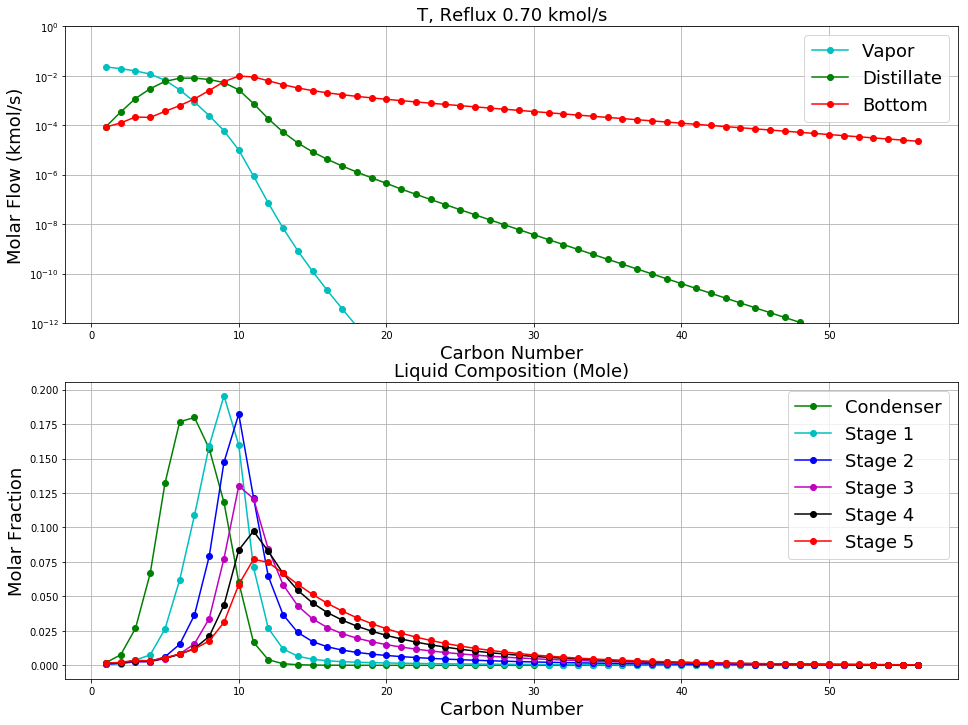

In [40]:
plot_distribution(7)

In [52]:
for i in m.COMP_ORG:
    print('{:10s}\t{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}'.format(i,cd_data['x'][i][7],\
    rf_data[1]['x'][i][7],rf_data[2]['x'][i][7],rf_data[3]['x'][i][7],rf_data[4]['x'][i][7],rf_data[5]['x'][i][7]))

C2H4      	0.003982	0.000776	0.000871	0.001036	0.001196	0.001363
C3H6      	0.021229	0.003041	0.002031	0.002301	0.002592	0.002884
C4H8      	0.048752	0.005402	0.001941	0.002037	0.002240	0.002432
C5H10     	0.080109	0.015406	0.003627	0.002941	0.003119	0.003322
C6H12     	0.109552	0.037170	0.009016	0.005011	0.004842	0.005012
C7H14     	0.112789	0.066035	0.021604	0.009316	0.007421	0.007240
C8H16     	0.099345	0.097600	0.047221	0.020085	0.012551	0.010718
C9H18     	0.075701	0.121753	0.089347	0.046127	0.025973	0.018628
C10H20    	0.039942	0.103064	0.114736	0.080245	0.050876	0.035403
C11H22    	0.007588	0.030907	0.051128	0.049322	0.038828	0.030239
C12H24    	0.001840	0.011675	0.027252	0.034724	0.033488	0.029801
C13H26    	0.000518	0.005068	0.015332	0.024009	0.027001	0.026769
C14H28    	0.000184	0.002752	0.009817	0.017592	0.021971	0.023553
C15H30    	0.000080	0.001801	0.007035	0.013661	0.018241	0.020631
C16H32    	0.000039	0.001337	0.005460	0.011087	0.015416	0.018058
C17H34    	0.000021	0.001